**Quick draw Recogniztion**

# AI Spring 2022 Final Project 

### Examples:
>https://www.kaggle.com/code/kotarojp/first-step-for-submission-keras-resnet50/notebook

>https://www.kaggle.com/code/gaborfodor/greyscale-mobilenet-lb-0-892






# 1. Install modules



In [1]:
#!pip install tensorflow
import tensorflow as tf
print('Using tensorflow version: ', tf.__version__)

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
import ast
import random
import cv2
import matplotlib.pyplot as plt
import gc
import json
from tensorflow.keras.applications import MobileNet, ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Using tensorflow version:  2.9.1


In [2]:
tf.random.set_seed(60)
np.random.seed(60)

In [3]:
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0Metal device set to: Apple M1 Pro



2022-06-13 19:15:01.882277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-13 19:15:01.882372: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## For Google Colab

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# 2. Preprocess Data

- Saved train_simplified directory in Google Drive.
- Total 340 classes of picture, each with at least 120 thousands data.
- To avoid long time training, we may choose only a part of them.

In [4]:
dir = os.path.join(os.getcwd(), 'train_simplified')

csv_paths = []
labels = []
count = 0
for file in os.listdir(dir):
  labels.append(file.split('.')[0])

dir = os.path.join(os.getcwd(), 'shuffled')
for file in os.listdir(dir):
    csv_paths.append(os.path.join(dir, file))

csv_paths.sort()
print(csv_paths[-1])
labels.sort()


/Users/chenvincent/Desktop/110下/Intro to AI/AI_Final/shuffled/valid_data.csv


# 3. Build Model 
- MobileNet

### Hyperparameters

In [5]:
BATCH_SIZE = 680
EPOCHS = 20
BASE_IMG_SIZE = 256
IMG_SIZE = 64

STEP_PER_EPOCH = 500

NUM_CLASS = 340


### Create Model

In [6]:
def top_3_accuracy(y_true, y_pred):
  return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_1_accuracy(y_true, y_pred):
  return top_k_categorical_accuracy(y_true, y_pred, k=1)

In [7]:
model = MobileNet(input_shape=(IMG_SIZE, IMG_SIZE, 1), alpha=1, weights=None, classes=NUM_CLASS)
model.compile(optimizer=Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=[categorical_crossentropy, top_1_accuracy, top_3_accuracy])


# model = ResNet50V2(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights=None, classes=NUM_CLASS)
# model.compile(optimizer=Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])

2022-06-13 19:15:01.908771: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-13 19:15:01.908790: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Show Model Structure

In [8]:
# print(model.summary())

# 4. Create One Hot Encoder

In [9]:
wordEncoder = LabelEncoder()
wordEncoder.fit(labels)

def oneHotEncoder(word):
  return to_categorical(wordEncoder.transform([word]), num_classes=NUM_CLASS).reshape((NUM_CLASS,1)) #ugly

# test_y = oneHotEncoder('The Eiffel Tower')
# print(test_y)
# b = [5]
# print(to_categorical(b, 6).reshape(6))
# print(wordEncoder.transform(['arm', 'asparagus', 'axe']))

# 5. Create Train Data Generator

In [10]:
def draw_image_cv2(strokes, img_size, thickness=6, time_color=True):
  img = np.zeros((BASE_IMG_SIZE, BASE_IMG_SIZE), np.uint8)
  for t, stroke in enumerate(strokes):
    for i in range(len(stroke[0])-1):
      color = 255 - min(t, 10) * 13 if time_color else 255
      _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i+1], stroke[1][i+1]),color, thickness)
  
  if img_size != BASE_IMG_SIZE:
    return cv2.resize(img, (img_size, img_size))
  else: 
    return img

def training_data_generator(batch_size, img_size, num_class, thickness=6, time_color=True):
  while True:
    for i in np.random.permutation(100):
        x = np.zeros((batch_size, img_size, img_size, 1))
        y = np.zeros((batch_size, NUM_CLASS, 1))
        df = pd.read_csv(csv_paths[i]).sample(n=batch_size)
        df['drawing'] = df['drawing'].apply(json.loads)
        for k, raw_strokes in enumerate(df['drawing']):
            x[k, :, :, 0] = draw_image_cv2(raw_strokes, img_size,thickness=6, time_color=time_color)
            y[k, :, :] = oneHotEncoder(df['word'].iloc[k])
        x = preprocess_input(x).astype(np.float32)
        yield x, y

def df_to_images(df, img_size, thickness=6, time_color=True):
  x = np.zeros((len(df), img_size, img_size, 1))
  df['drawing'] = df['drawing'].apply(json.loads)
  for i , raw_strokes in enumerate(df['drawing']):
    x[i, :, :, 0] = draw_image_cv2(raw_strokes, img_size = img_size)
  x = preprocess_input(x).astype(np.float32)
  return x

# Train all data in one epoch version



In [ ]:
# def draw_image_cv2(strokes, img_size, thickness=6, time_color=True):
#   img = np.zeros((BASE_IMG_SIZE, BASE_IMG_SIZE), np.uint8)
#   for t, stroke in enumerate(strokes):
#     for i in range(len(stroke[0])-1):
#       color = 255 - min(t, 10) * 13 if time_color else 255
#       _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i+1], stroke[1][i+1]),color, thickness)
  
#   if img_size != BASE_IMG_SIZE:
#     return cv2.resize(img, (img_size, img_size))
#   else: 
#     return img

# def training_data_generator(batch_size, img_size, num_class, ks, thickness=6, time_color=True):
#   while True:
#     for k in np.random.permutation(ks):
#       for df in pd.read_csv(csv_paths[k], chunksize=batch_size):
#         x = np.zeros((batch_size, img_size, img_size, 1))
#         y = np.zeros((batch_size, NUM_CLASS, 1))
#         df['drawing'] = df['drawing'].apply(json.loads)
#         for k, raw_strokes in enumerate(df['drawing']):
#           x[k, :, :, 0] = draw_image_cv2(raw_strokes, img_size,thickness=6, time_color=time_color)
#           y[k, :, :] = oneHotEncoder(df['word'].iloc[k])
#         x = preprocess_input(x).astype(np.float32)
#         yield x, y

# def df_to_images(df, img_size, thickness=6, time_color=True):
#   x = np.zeros((len(df), img_size, img_size, 1))
#   df['drawing'] = df['drawing'].apply(json.loads)
#   for i , raw_strokes in enumerate(df['drawing']):
#     x[i, :, :, 0] = draw_image_cv2(raw_strokes, img_size = img_size)
#   x = preprocess_input(x).astype(np.float32)
#   return x

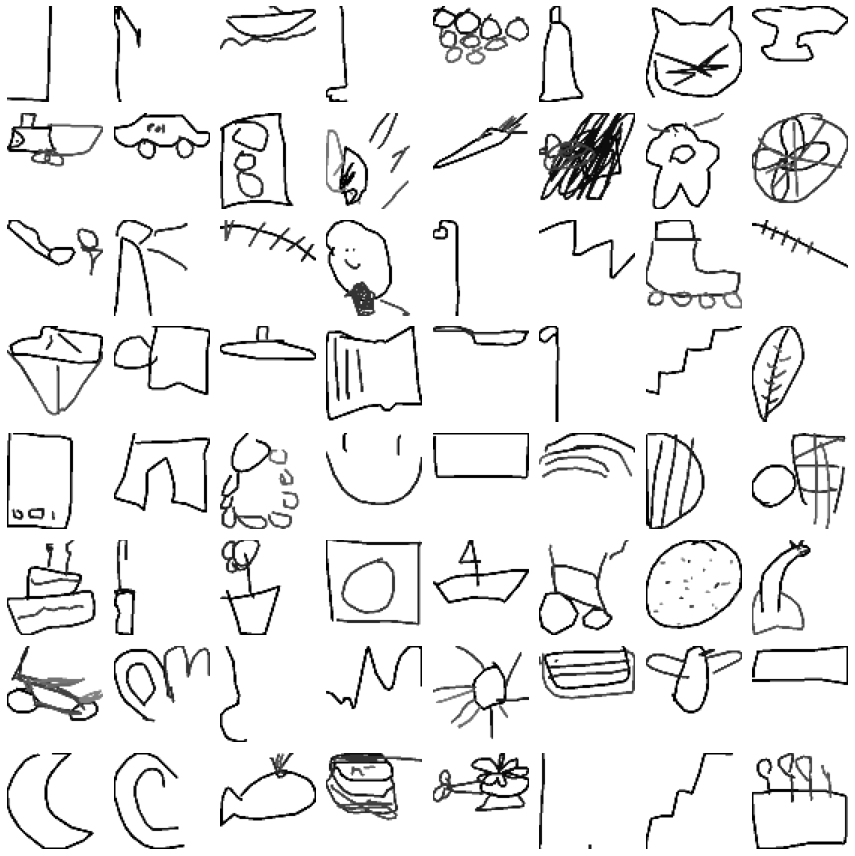

In [11]:
train_datagen = training_data_generator(batch_size = BATCH_SIZE, img_size = IMG_SIZE, num_class=340, time_color=True)

x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();


# 6. Create Validation Data

In [12]:
def create_validation_set(class_num, img_size, thickness=6, time_color=True):
  
    x = np.zeros((34000, img_size, img_size, 1))
    y = np.zeros((34000, NUM_CLASS, 1))

    df = pd.read_csv(csv_paths[-1]) 
    df['drawing'] = df['drawing'].apply(json.loads)
    print(csv_paths[-1])
    for k, raw_strokes in enumerate(df['drawing']):
        x[k,:,:,0] = draw_image_cv2(raw_strokes, img_size, thickness=thickness, time_color=time_color)
        y[k,:,:] = oneHotEncoder(df['word'].iloc[k])
    x = preprocess_input(x).astype(np.float32)
    del(df)
    gc.collect()
    return x, y

In [13]:
x_valid, y_valid = create_validation_set(NUM_CLASS, IMG_SIZE, 6, False)
print(x_valid.shape, y_valid.shape)


/Users/chenvincent/Desktop/110下/Intro to AI/AI_Final/shuffled/valid_data.csv
(34000, 64, 64, 1) (34000, 340, 1)


# 7. Training

In [14]:
callbacks = [
             ReduceLROnPlateau(monitor="val_top_3_accuracy", factor = 0.75, patience = 3, min_delta=0.001,mode='max', min_lr=1e-5, verbose=1),
             ModelCheckpoint('model.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True,
                    ),# save_weights_only=True
]

In [15]:
histories = []
history = model.fit(train_datagen, epochs = EPOCHS, steps_per_epoch=STEP_PER_EPOCH, verbose=1, validation_data=(x_valid, y_valid), callbacks=callbacks)
histories.append(history)
print(histories)

Epoch 1/20


2022-06-13 19:15:13.548656: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-13 19:15:14.579359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 3.2514 - categorical_crossentropy: 3.2514 - top_1_accuracy: 0.2912 - top_3_accuracy: 0.4658

2022-06-13 19:18:17.100393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 199s 394ms/step - loss: 3.2514 - categorical_crossentropy: 3.2514 - top_1_accuracy: 0.2912 - top_3_accuracy: 0.4658 - val_loss: 7.2656 - val_categorical_crossentropy: 7.2656 - val_top_1_accuracy: 0.0076 - val_top_3_accuracy: 0.0157 - lr: 0.0020
Epoch 2/20
500/500 [==============================] - 195s 388ms/step - loss: 1.8685 - categorical_crossentropy: 1.8685 - top_1_accuracy: 0.5410 - top_3_accuracy: 0.7484 - val_loss: 2.9335 - val_categorical_crossentropy: 2.9335 - val_top_1_accuracy: 0.3840 - val_top_3_accuracy: 0.5875 - lr: 0.0020
Epoch 3/20
500/500 [==============================] - 196s 392ms/step - loss: 1.5816 - categorical_crossentropy: 1.5816 - top_1_accuracy: 0.6053 - top_3_accuracy: 0.7997 - val_loss: 2.6559 - val_categorical_crossentropy: 2.6559 - val_top_1_accuracy: 0.4206 - val_top_3_accuracy: 0.6289 - lr: 0.0020
Epoch 4/20
500/500 [==============================] - 194s 388ms/step - loss: 1.4426 - categorical_crossentropy: 1

# 8. Learning Curve

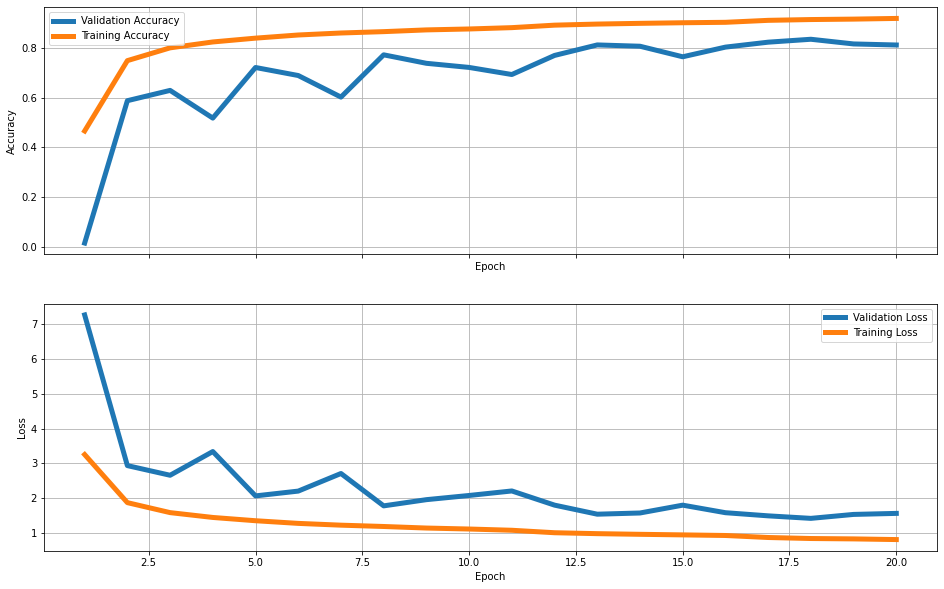

In [16]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in histories], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df['val_top_3_accuracy'], lw=5, label='Validation Accuracy')
axs[0].plot(hist_df['top_3_accuracy'], lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df['val_loss'], lw=5, label='Validation Loss')
axs[1].plot(hist_df['loss'], lw=5, label='Training Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();


# 9. Generate Prediction

In [18]:
model.load_weights(os.path.join(os.getcwd(), 'model.h5'))

In [19]:
test = pd.read_csv(os.path.join(os.getcwd(), 'test_simplified.csv'))
test.head()
x_test = df_to_images(test, IMG_SIZE)
print(test.shape, x_test.shape)

(112199, 3) (112199, 64, 64, 1)


In [20]:
def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

In [21]:
test_predict = model.predict(x_test,batch_size=128, verbose=1)

top3_ID = preds2catids(test_predict)

id_to_category = {k: cat.replace(' ','_') for k, cat in enumerate(labels)}

top3_category = top3_ID.replace(id_to_category)

test['word'] = top3_category['a']+' '+top3_category['b']+' '+top3_category['c']

submission = test[['key_id', 'word']]

submission.to_csv('submission.csv', index=False)

submission.shape

2022-06-13 20:34:03.862677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


877/877 [==============================] - 21s 23ms/step


(112199, 2)